# Culinary Recommendation in Tangerang¶

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup

## 1. Web Scraping to gather all boroughs & districts name in Tangerang

In [2]:
# wiki = 'https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kabupaten_Tangerang'
# wiki_page = requests.get(wiki)

# wiki_raw = pd.read_html(wiki_page.content, header = 0)[0]

# # Clean up the table 
# df = wiki_raw[:-1]
# df

In [3]:
wiki = 'https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kabupaten_Tangerang'
wiki_page = requests.get(wiki)
soup = BeautifulSoup(wiki_page.content,"html.parser")
content = soup.findAll('tr')

# Looping through
dis_num = 0
tangerang_list, district_list, district_text = [], [], ''

for i in range(1, len(content)-1):
    # loop through position
    pos = 0

    if len(content[i].findAll('td'))==6 :
        for j in content[i].findAll('td'):
            pos+=1
            # At second column, get the borough
            if pos==2:
                borough = j.text.strip().split('\n')[0]
            elif pos==6:
                district_list.extend(j.text.strip().split('\n'))
        if len(content[i+1].findAll('td'))!=2:
            for d in range(len(district_list)):
                if d<len(district_list)-1:
                    district_text = district_text + district_list[d] + ', '
                else:
                    district_text = district_text + district_list[d]
            tangerang_list.append({'borough': borough, 'number_of_neighbourhoods': len(district_list), 'neighbourhoods': district_text})
            district_list, district_text, borough =[],'', ''
    elif len(content[i].findAll('td'))==2:
        for j in content[i].findAll('td'):
            pos+=1
            if pos==2:
                district_list.extend(j.text.strip().split('\n'))
                for d in range(len(district_list)):
                    if d<len(district_list)-1:
                        district_text = district_text + district_list[d] + ', '
                    else:
                        district_text = district_text + district_list[d]
                tangerang_list.append({'borough': borough, 'number_of_neighbourhoods': len(district_list), 'neighbourhoods': district_text})
                district_list, district_text, borough =[],'',''


# Export the beautiful_soup result to df
tangerang_df= pd.DataFrame(tangerang_list)[:-1]
tangerang_df

,borough,number_of_neighbourhoods,neighbourhoods
0,Balaraja,9,"Cangkudu, Gembong, Saga, Sentul, Sentul Jaya, ..."
1,Cikupa,14,"Bitung Jaya, Bojong, Budi Mulya, Cibadak, Ciku..."
2,Cisauk,6,"Cibogo, Dangdang, Mekar Wangi, Sampora, Suradi..."
3,Cisoka,10,"Bojong Loa, Carenang, Caringin, Cempaka, Cibug..."
4,Curug,7,"Cukanggalih, Curug Wetan, Kadu, Kadu Jaya, Bin..."
5,Gunung Kaler,9,"Cibetok, Cipaeh, Gunung Kaler, Kandawati, Kedu..."
6,Jambe,10,"Ancol Pasir, Daru, Jambe, Kutruk, Mekarsari, P..."
7,Jayanti,8,"Cikande, Dangdeur, Jayanti, Pabuaran, Pangkat,..."
8,Kelapa Dua,6,"Curug Sangereng, Bencongan, Bencongan Indah, B..."
9,Kemiri,7,"Karang Anyar, Kemiri, Klebet, Legok Suka Maju,..."


## 2. Find all neighbourhoods geolocation (latitude & longitude) including postal code from JSON and CSV files

In [4]:
banten_province_geojson = 'data/json/area/62/36/36.json'

try:
    with open(banten_province_geojson) as f:
        json36 = json.load(f)
except:
    print('An error occured.')

borough_code = []
for i in json36['children']:
    borough_code.append(i)
borough_code.pop(0)

df_districts = pd.read_csv('data/csv/62/subDistricts.csv')

df_districts = df_districts[df_districts['Parent'].apply(lambda x : x in borough_code)][['Name','Latitude','Longitude','Postal']].reset_index(drop=True)
df_districts['Name'] = df_districts['Name'].apply(lambda x : x.upper())
df_districts = df_districts.rename(columns={'Name':'neighbourhoods'})
display(df_districts.head())

,neighbourhoods,Latitude,Longitude,Postal
0,MALINGPING,-6.755530,106.007690,42391
1,WANASALAM,-6.761585,105.919716,42396
2,PANGGARANGAN,-6.831495,106.232450,"42394,42395,42392,42390"
3,CIHARA,-6.837930,106.113282,"42394,42398,42392"
4,BAYAH,-6.897934,106.297370,42393


In [5]:
col = list(tangerang_df.columns)
col.remove('number_of_neighbourhoods')
tangerang_ds = pd.DataFrame(columns=col)
for i,v in enumerate(tangerang_df.values):
    tangerang_ds = tangerang_ds.append(pd.DataFrame({col[0]:v[0], col[1]:v[2].upper().split(', ')}), ignore_index=True)
tangerang = pd.merge(tangerang_ds, df_districts, how='inner', on='neighbourhoods')
display(tangerang.head())

,borough,neighbourhoods,Latitude,Longitude,Postal
0,Balaraja,BALARAJA,-6.200180,106.436878,"15611,15612,15613,15614,15615,15616,15617,1561..."
1,Cikupa,CIBADAK,-6.340584,106.224435,42357
2,Cikupa,CIKUPA,-6.217129,106.513105,15710
3,Cikupa,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563..."
4,Sukamulya,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563..."


## 3. Population number for each neighbourhood from CSV file

In [6]:
# Download the 2016 from here first: https://tangerangkab.bps.go.id/statictable/download.html?nrbvfeve=NjE%3D&sdfs=ldjfdifsdjkfahi&zxcv=L2JhY2tlbmQ%3D&xzmn=aHR0cHM6Ly90YW5nZXJhbmdrYWIuYnBzLmdvLmlkL3N0YXRpY3RhYmxlLzIwMTgvMDIvMDIvNjEvanVtbGFoLXBlbmR1ZHVrLWJlcmRhc2Fya2FuLWplbmlzLWtlbGFtaW4tbWVudXJ1dC1rZWNhbWF0YW4tZGkta2FidXBhdGVuLXRhbmdlcmFuZy0tMjAxNi5odG1s&twoadfnoarfeauf=MjAyMS0wMS0wNiAxNjo0NTo0MA%3D%3D

df_population = pd.read_excel('data/tangerang_population.xls', skiprows=4).drop(index=[0, 30])
df_population = df_population.rename(columns={'Unnamed: 1': 'borough', 'Total':'population'}).reset_index().drop(columns=['Subdistrict', 'index'])
df_population.head()

,borough,Male,Female,population,Sex Ratio
0,Cisoka,48693,45423,94116,"107,20"
1,Solear,46385,44561,90946,"104,09"
2,Tigaraksa,79151,75746,154897,"104,50"
3,Jambe,23082,21891,44973,"105,44"
4,Cikupa,144465,135320,279785,"106,76"


## 4. Finalize Tangerang's dataset that will be used

In [7]:
df_tangerang = pd.merge(tangerang, df_population[['borough','population']], how='inner', on='borough')
df_tangerang.to_csv(r'data/Tangerang_final.csv', index = False, header=True) # export data
display(df_tangerang.head())
print(('-'*100)+'\n', df_tangerang.isna().sum(), end='\n'+('-'*100)+'\n\n') # Check null value for our final Tangerang's dataset
display(df_tangerang.info()) # # Check the integrity of datatype in our dataset's features

,borough,neighbourhoods,Latitude,Longitude,Postal,population
0,Balaraja,BALARAJA,-6.200180,106.436878,"15611,15612,15613,15614,15615,15616,15617,1561...",131566
1,Cikupa,CIBADAK,-6.340584,106.224435,42357,279785
2,Cikupa,CIKUPA,-6.217129,106.513105,15710,279785
3,Cikupa,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563...",279785
4,Sukamulya,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563...",65911


----------------------------------------------------------------------------------------------------
 borough           0
neighbourhoods    0
Latitude          0
Longitude         0
Postal            0
population        0
dtype: int64
----------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   borough         33 non-null     object 
 1   neighbourhoods  33 non-null     object 
 2   Latitude        33 non-null     float64
 3   Longitude       33 non-null     float64
 4   Postal          33 non-null     object 
 5   population      33 non-null     object 
dtypes: float64(2), object(4)
memory usage: 1.8+ KB


None

## Start map the data using geocorder & folium

In [8]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import geocoder

In [9]:
df_tangerang = pd.read_csv('data/Tangerang_final.csv')
df_tangerang.head()

,borough,neighbourhoods,Latitude,Longitude,Postal,population
0,Balaraja,BALARAJA,-6.200180,106.436878,"15611,15612,15613,15614,15615,15616,15617,1561...",131566
1,Cikupa,CIBADAK,-6.340584,106.224435,42357,279785
2,Cikupa,CIKUPA,-6.217129,106.513105,15710,279785
3,Cikupa,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563...",279785
4,Sukamulya,SUKAMULYA,-6.158935,106.439735,"15631,15632,15633,15634,15635,15636,15637,1563...",65911


## 5. Get Geolocation Coordinate of Tangerang, Indonesia

In [10]:
loc = 'Tangerang, Indonesia'
geoloc = Nominatim(user_agent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36')
maps = geoloc.geocode(loc)
lat = maps.latitude
lon = maps.longitude
print(f'The coordinate of Tangerang, Indonesia : {lat}, {lon}')

The coordinate of Tangerang, Indonesia : -6.1760311, 106.6384468


## 6. Create a Map of Tangerang with All Neighbourhoods

In [11]:
map_tangerang = folium.Map(location=[lat,lon], zoom_start=12)

for la, ln, bor, nei in zip(df_tangerang['Latitude'],df_tangerang['Longitude'],df_tangerang['borough'],df_tangerang['neighbourhoods']):
    label = folium.Popup(f'{nei}, {bor}', parse_html=True)
    folium.CircleMarker([la,ln], radius=10, popup=label, color='#00C600', fill=True, fill_color='00D800', fill_opacity=0.7, parse_html=False).add_to(map_tangerang)

map_tangerang

In [12]:
import pandas as pd
import requests
import json


## 7. Define Foursquare API credentials

In [13]:
CLIENT_ID = '4UICRANEEUH3PZ3V4J5AJRU3HDNZ33HK0ASJEHEBCMHK2C0D' # your Foursquare ID
CLIENT_SECRET = 'J0YIUBTCIT5QHZYUDFGAVXIOUIMV0VUKBSSATYHA1TTPSSY5' # your Foursquare Secret
ACCESS_TOKEN = 'AMR5DRX4VJRX5AE1FUJUVDTZCOFT1JVJCFSXDM2XKZBHHRHG' # your FourSquare Access Token
VERSION = '20180604' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

## 8. Define a function to execute Foursquare API (https://api.foursquare.com/v2/venues/search)

In [14]:
def getTopPopularRestaurants(bor, names, latitudes, longitudes, category_id, radius=500, limit=100):
    
    venues_list=[]
    for b, name, lat, lng in zip(bor, names, latitudes, longitudes):
        print('fetching restaurants in',name+'\'s area')
        url = f'https://api.foursquare.com/v2/venues/search?\
        &client_id={CLIENT_ID}\
        &client_secret={CLIENT_SECRET}\
        &v={VERSION}\
        &ll={lat},{lng}\
        &categoryId={category_id}\
        &radius={radius}\
        &limit={limit}\
        &sortByPopularity=True'
        hdrs = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

        try:
            resp = requests.get(url,headers=hdrs)
            results = resp.json()["response"]['venues']
        except:
            print('An error occured.')
        
        venues_list.append([(b, name, lat, lng, v['name'], v['location']['lat'], v['location']['lng'], v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 'Neighborhood', 'Neighborhood_Latitude', 'Neighborhood_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category']
    
    return(nearby_venues)

## 9. Use Foursquare API to explore most popular restaurants near Tangerang neighborhoods

In [15]:
# https://developer.foursquare.com/docs/build-with-foursquare/categories/ as source
# import food category id dataset
food_cat_id = pd.read_csv('data/foursquare_FoodCategory.csv')
food_cat_id.drop(index=[25], axis=0, inplace=True)
food_cat_id.reset_index(drop=True, inplace=True)
display(food_cat_id)

,food_category,id
0,American,4bf58dd8d48988d14e941735
1,Australian,4bf58dd8d48988d169941735
2,Eastern European,4bf58dd8d48988d109941735
3,English,52e81612bcbc57f1066b7a05
4,French,4bf58dd8d48988d10c941735
5,Halal,52e81612bcbc57f1066b79ff
6,Indian,4bf58dd8d48988d10f941735
7,Latin American,4bf58dd8d48988d1be941735
8,Mexican,4bf58dd8d48988d1c1941735
9,Burrito,4bf58dd8d48988d153941735


In [16]:
tangerang_restaurants = getTopPopularRestaurants(bor = df_tangerang['borough'],
                                                names=df_tangerang['neighbourhoods'],
                                                latitudes=df_tangerang['Latitude'],
                                                longitudes=df_tangerang['Longitude'],
                                                category_id=','.join(food_cat_id['id'].values),
                                                radius=3000, limit=200
                                                )

fetching restaurants in BALARAJA's area
fetching restaurants in CIBADAK's area
fetching restaurants in CIKUPA's area
fetching restaurants in SUKAMULYA's area
fetching restaurants in SUKAMULYA's area
fetching restaurants in BENDA's area
fetching restaurants in CISAUK's area
fetching restaurants in CARENANG's area
fetching restaurants in CISOKA's area
fetching restaurants in GUNUNG KALER's area
fetching restaurants in JAMBE's area
fetching restaurants in CIKANDE's area
fetching restaurants in JAYANTI's area
fetching restaurants in PABUARAN's area
fetching restaurants in KELAPA DUA's area
fetching restaurants in KEMIRI's area
fetching restaurants in KRESEK's area
fetching restaurants in KRONJO's area
fetching restaurants in LEGOK's area
fetching restaurants in GUNUNG SARI's area
fetching restaurants in PAGEDANGAN's area
fetching restaurants in PAKUHAJI's area
fetching restaurants in PANONGAN's area
fetching restaurants in RAJEG's area
fetching restaurants in SEPATAN's area
fetching restau

## 10. Remove unwanted categories from Jakarta's restaurant dataset

In [17]:
blacklisted = ['Farm','Hotel','Bakery','Ice Cream Shop','Bakery','Lounge''Grocery Store','Bar','Concert Hall','Convenience Store','Movie Theater','Poke Place','Residential Building (Apartment / Condo)']

tangerang_restaurants = tangerang_restaurants[tangerang_restaurants['Venue_Category'].apply(lambda x : x not in blacklisted)]
tangerang_restaurants = tangerang_restaurants.reset_index(drop=True)
display(tangerang_restaurants)

,Borough,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Balaraja,BALARAJA,-6.200180,106.436878,Pondok Bakso & Mie Ayam Lesehan,-6.203863,106.446477,Indonesian Meatball Place
1,Balaraja,BALARAJA,-6.200180,106.436878,ketoprak siram Cirebon,-6.197587,106.457925,Arepa Restaurant
2,Balaraja,BALARAJA,-6.200180,106.436878,Bubur ayam depan Bank bjb balaraja,-6.206176,106.450310,Belarusian Restaurant
3,Balaraja,BALARAJA,-6.200180,106.436878,Pizza Hut,-6.193828,106.463528,Pizza Place
4,Balaraja,BALARAJA,-6.200180,106.436878,Baso titotti cibadak,-6.194339,106.459852,Dumpling Restaurant
...,...,...,...,...,...,...,...,...
612,Tigaraksa,TIGARAKSA,-6.259875,106.469015,Mie Ayam & Bakso Raos Enggal,-6.273792,106.489896,Indonesian Meatball Place
613,Tigaraksa,TIGARAKSA,-6.259875,106.469015,Chiku kopitiam,-6.245380,106.491000,Chinese Restaurant
614,Tigaraksa,TIGARAKSA,-6.259875,106.469015,rumah makan 898,-6.278884,106.476205,Chinese Restaurant
615,Tigaraksa,TIGARAKSA,-6.259875,106.469015,Mie Ayam Bangka Bojen,-6.270629,106.490354,Chinese Restaurant


In [18]:
# Final check for Tangerang's restaurant dataset
tangerang_restaurants.isna().sum()

Borough                   0
Neighborhood              0
Neighborhood_Latitude     0
Neighborhood_Longitude    0
Venue                     0
Venue_Latitude            0
Venue_Longitude           0
Venue_Category            0
dtype: int64

In [19]:
# Check how many restaurants for each category in every neighborhood
tangerang_restaurants.groupby(['Neighborhood','Venue_Category']).count()['Venue'].head(50)

Neighborhood  Venue_Category           
BALARAJA      American Restaurant          2
              Arepa Restaurant             1
              Australian Restaurant        1
              Belarusian Restaurant        1
              Betawinese Restaurant        1
              Buffet                       1
              Dim Sum Restaurant           1
              Dumpling Restaurant          5
              Fast Food Restaurant         1
              Halal Restaurant             1
              Indonesian Meatball Place    3
              Latin American Restaurant    1
              Noodle House                 5
              Padangnese Restaurant        2
              Pizza Place                  2
              Seafood Restaurant           1
              Sundanese Restaurant         1
BENDA         American Restaurant          2
              Balinese Restaurant          1
              Buffet                       1
              Café                         1
              C

In [20]:
print('There are {} different categories in tangerang_restaurants\' dataset'.format(len(tangerang_restaurants['Venue_Category'].unique())))
print('There are {} restaurants found in Tangerang area'.format(len(tangerang_restaurants)))

There are 57 different categories in tangerang_restaurants' dataset
There are 617 restaurants found in Tangerang area


In [21]:
tangerang_restaurants.to_csv(r'data\Tangerang_restaurants.csv', index = False, header=True)

## 11. Visualize all restaurants in Tangerang are

In [22]:
map_tangerang = folium.Map(location=[lat,lon], zoom_start=12)

# Central point of each neighborhood with green circle
for la, ln, bor, nei in zip(df_tangerang['Latitude'],df_tangerang['Longitude'],df_tangerang['borough'],df_tangerang['neighbourhoods']):
    label = folium.Popup(f'{nei}, {bor}', parse_html=True)
    folium.CircleMarker([la,ln], radius=10, popup=label, color='#00C600', fill=True, fill_color='00D800', fill_opacity=0.7, parse_html=False).add_to(map_tangerang)

# location of all restaurants from the dataset mapped with geolocation (gold circle)
for la, ln, ven, cat in zip(tangerang_restaurants['Venue_Latitude'],tangerang_restaurants['Venue_Longitude'],tangerang_restaurants['Venue'], tangerang_restaurants['Venue_Category']):
    label = folium.Popup(f'{ven}, {cat}', parse_html=True)
    folium.CircleMarker([la,ln], radius=5, popup=label, color='#C68A00', fill=True, fill_color='#F6AB00', fill_opacity=0.7, parse_html=False).add_to(map_tangerang)

map_tangerang

## 12. Apply One-Hot Encoding to analyze neighborhoods

In [23]:
tangerang_restaurants = pd.read_csv('data/Tangerang_restaurants.csv')

In [24]:
tangerang_ohe = pd.get_dummies(data=tangerang_restaurants['Venue_Category'],prefix='',prefix_sep='')
tangerang_ohe['borough'] = tangerang_restaurants['Borough']
tangerang_ohe['neighborhood'] = tangerang_restaurants['Neighborhood']
tangerang_ohe = tangerang_ohe[tangerang_ohe.columns[-2:].values.tolist() + tangerang_ohe.columns[:-2].values.tolist()]

display(tangerang_ohe.head())

,borough,neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Balinese Restaurant,Belarusian Restaurant,...,Shabu-Shabu Restaurant,South American Restaurant,Spanish Restaurant,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Taco Place,Thai Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant
0,Balaraja,BALARAJA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balaraja,BALARAJA,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balaraja,BALARAJA,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Balaraja,BALARAJA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balaraja,BALARAJA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 13. Group the dataset by neighborhood and take mean of the frequency of occurrence in each category

In [25]:
tangerang_gr = tangerang_ohe.groupby(['borough','neighborhood']).mean().reset_index(drop=False)
display(tangerang_gr.head())

,borough,neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Balinese Restaurant,Belarusian Restaurant,...,Shabu-Shabu Restaurant,South American Restaurant,Spanish Restaurant,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Taco Place,Thai Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant
0,Balaraja,BALARAJA,0.066667,0.033333,0.0,0.0,0.033333,0.0,0.0,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.0,0.0
1,Cikupa,CIBADAK,0.088889,0.022222,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.044444,0.0,0.022222,0.0,0.0,0.0
2,Cikupa,CIKUPA,0.044444,0.022222,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.022222,0.044444,0.022222,0.0,0.000000,0.0,0.0,0.0
3,Cikupa,SUKAMULYA,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,Cisauk,CISAUK,0.021739,0.000000,0.0,0.0,0.021739,0.0,0.0,0.000000,...,0.021739,0.021739,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


## 14. Define a function to get the most appear restaurants

In [26]:
def freq_rest(r,n):
    row_cat = r.iloc[2:].sort_values(ascending=False)
    return row_cat.index.values[0:n]

In [27]:
# Create columns' name
rank = ['st','nd','rd','th']
col = ['neighborhood'] + [f'{i+1}{rank[i]} most appear category' if i<3 else f'{i+1}{rank[3]} most appear category' for i in range(5)]

# Create a dataset
tangerang_top_five = pd.DataFrame(columns=col)
tangerang_top_five['neighborhood'] = tangerang_gr['neighborhood']
for i in range(len(tangerang_gr)):
    tangerang_top_five.iloc[i,1:] = freq_rest(tangerang_gr.iloc[i,:], 5)

display(tangerang_top_five)

,neighborhood,1st most appear category,2nd most appear category,3rd most appear category,4th most appear category,5th most appear category
0,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place
1,CIBADAK,Noodle House,Javanese Restaurant,Seafood Restaurant,Chinese Restaurant,American Restaurant
2,CIKUPA,Noodle House,Seafood Restaurant,Chinese Restaurant,Indonesian Meatball Place,Pizza Place
3,SUKAMULYA,Indian Restaurant,Dumpling Restaurant,Seafood Restaurant,Dim Sum Restaurant,Cafeteria
4,CISAUK,Noodle House,Chinese Restaurant,Javanese Restaurant,Satay Restaurant,Pizza Place
5,CISOKA,Indonesian Meatball Place,Sundanese Restaurant,Steakhouse,Cafeteria,Halal Restaurant
6,JAMBE,Indonesian Meatball Place,Sundanese Restaurant,Seafood Restaurant,Noodle House,Cafeteria
7,CIKANDE,Noodle House,Chinese Restaurant,Burrito Place,Korean Restaurant,Middle Eastern Restaurant
8,JAYANTI,Noodle House,American Restaurant,Padangnese Restaurant,Middle Eastern Restaurant,Indonesian Meatball Place
9,PABUARAN,Malay Restaurant,Vegetarian / Vegan Restaurant,Café,Halal Restaurant,Grocery Store


## 15. Find the optimal k value for K-Means Clustering

In [28]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

mpl.style.use('ggplot')

%matplotlib inline

D:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


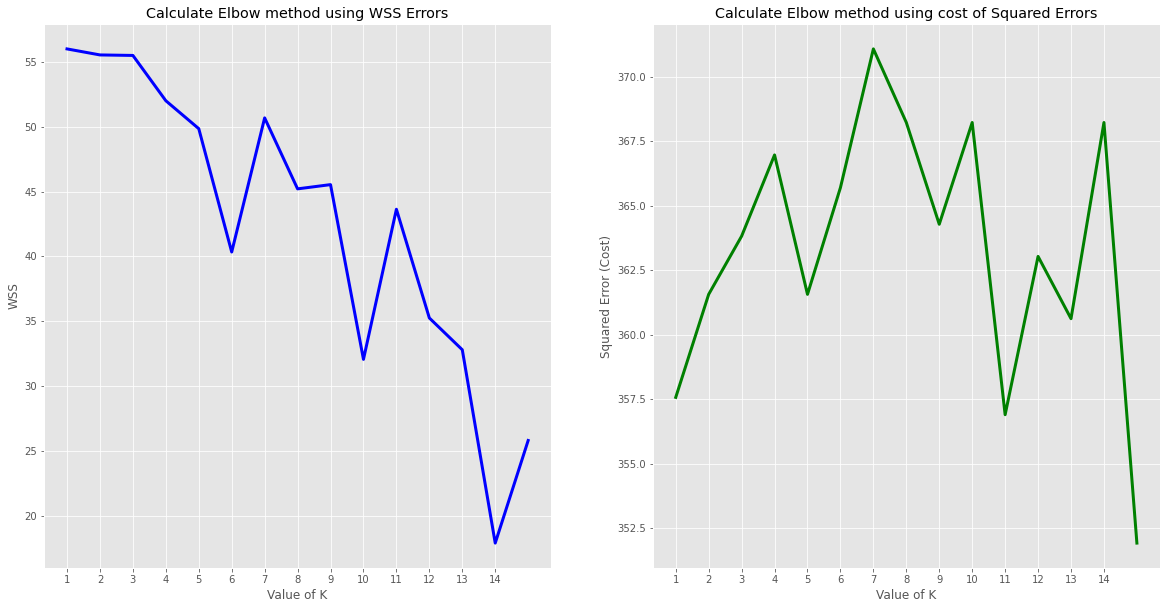

In [29]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

Ks = 15
sse = []

for n in range(1,Ks+1):
    x = StandardScaler().fit_transform(tangerang_gr.drop(['borough','neighborhood'],axis=1).values)
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=12).fit(x)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(x)
    curr_sse = 0

    for i in range(len(x)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (x[i, 0] - curr_center[0]) ** 2 + (x[i, 1] - curr_center[1]) ** 2
    
    sse.append(curr_sse)

ax0.plot(range(1,Ks+1), sse, color='b', linewidth='3')
ax0.set_title('Calculate Elbow method using WSS Errors')
ax0.set_xticks(np.arange(1,Ks,1))
ax0.set_xlabel('Value of K')
ax0.set_ylabel('WSS')

# =========================================================================

cost = [] 
for i in range(1, Ks+1): 
    KM = KMeans(n_clusters=n, init='k-means++', n_init=12) 
    KM.fit(StandardScaler().fit_transform(tangerang_gr.drop(['borough','neighborhood'],axis=1).values)) 
      
    cost.append(KM.inertia_)      
  
ax1.plot(range(1, Ks+1), cost, color ='g', linewidth ='3') 
ax1.set_title('Calculate Elbow method using cost of Squared Errors')
ax1.set_xticks(np.arange(1,Ks,1))
ax1.set_xlabel("Value of K") 
ax1.set_ylabel("Squared Error (Cost)") 

plt.show()

From what we can see, the best elbow point is at k=12

## 16. Let's run K-means algorithm for cluster

In [30]:
k = 12
x = tangerang_gr.drop(['borough','neighborhood'],axis=1).values
x = StandardScaler().fit_transform(x)
km = KMeans(n_clusters=k, init='k-means++', n_init=12)
km.fit(x)

KMeans(n_clusters=12, n_init=12)

## 17. Add cluster's label into dataset

In [31]:
tangerang_gr['cluster'] = km.labels_
tangerang_gr.groupby('cluster')['neighborhood'].count()

cluster
0      1
1      4
2     11
3      1
4      1
5      1
6      1
7      1
8      4
9      1
10     1
11     1
Name: neighborhood, dtype: int64

In [32]:
tangerang_top = tangerang_top_five.merge(tangerang_gr, on='neighborhood')
display(tangerang_top.head())

,neighborhood,1st most appear category,2nd most appear category,3rd most appear category,4th most appear category,5th most appear category,borough,American Restaurant,Arepa Restaurant,Argentinian Restaurant,...,South American Restaurant,Spanish Restaurant,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Taco Place,Thai Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,cluster
0,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.0,0.0,9
1,CIBADAK,Noodle House,Javanese Restaurant,Seafood Restaurant,Chinese Restaurant,American Restaurant,Cikupa,0.088889,0.022222,0.0,...,0.0,0.000000,0.000000,0.044444,0.0,0.022222,0.0,0.0,0.0,2
2,CIKUPA,Noodle House,Seafood Restaurant,Chinese Restaurant,Indonesian Meatball Place,Pizza Place,Cikupa,0.044444,0.022222,0.0,...,0.0,0.022222,0.044444,0.022222,0.0,0.000000,0.0,0.0,0.0,1
3,SUKAMULYA,Indian Restaurant,Dumpling Restaurant,Seafood Restaurant,Dim Sum Restaurant,Cafeteria,Cikupa,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,8
4,SUKAMULYA,Indian Restaurant,Dumpling Restaurant,Seafood Restaurant,Dim Sum Restaurant,Cafeteria,Sukamulya,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,8


In [33]:
tr = tangerang_restaurants.rename(columns={'Neighborhood':'neighborhood'})
tangerang_top = tangerang_top.merge(tr, on='neighborhood')
display(tangerang_top.head())

,neighborhood,1st most appear category,2nd most appear category,3rd most appear category,4th most appear category,5th most appear category,borough,American Restaurant,Arepa Restaurant,Argentinian Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,cluster,Borough,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.0,9,Balaraja,-6.20018,106.436878,Pondok Bakso & Mie Ayam Lesehan,-6.203863,106.446477,Indonesian Meatball Place
1,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.0,9,Balaraja,-6.20018,106.436878,ketoprak siram Cirebon,-6.197587,106.457925,Arepa Restaurant
2,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.0,9,Balaraja,-6.20018,106.436878,Bubur ayam depan Bank bjb balaraja,-6.206176,106.450310,Belarusian Restaurant
3,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.0,9,Balaraja,-6.20018,106.436878,Pizza Hut,-6.193828,106.463528,Pizza Place
4,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,0.0,0.0,9,Balaraja,-6.20018,106.436878,Baso titotti cibadak,-6.194339,106.459852,Dumpling Restaurant


In [34]:
tangerang_top.to_csv(r'Data\tangerang_cluster.csv', index = False, header=True)

## 18. Visualize the cluster

In [35]:
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(15)]
c_arr = mpl.cm.rainbow(np.linspace(0, 1, len(ys)))
rb = [colors.rgb2hex(i) for i in c_arr]

map_tangerang = folium.Map(location=[lat,lon], zoom_start=12)

for la, ln, nei, cat, clu in zip(tangerang_top['Venue_Latitude'],tangerang_top['Venue_Longitude'],tangerang_top['neighborhood'], tangerang_top['Venue_Category'], tangerang_top['cluster']):
    label = folium.Popup(f'{nei} (cluster {clu})', parse_html=True)
    folium.CircleMarker([la,ln], radius=5, popup=label, color=rb[clu-1], fill=True, fill_color=rb[clu-1], fill_opacity=0.7, parse_html=False).add_to(map_tangerang)

map_tangerang

## 19. Get neighborhoods' population numbers

In [36]:
import pandas as pd
import numpy as np

In [37]:
df_tangerang = pd.read_csv('Data/Tangerang_final.csv')

tangerang_pop = df_tangerang[['borough','neighbourhoods','population']].copy()
tangerang_pop.rename(columns={'neighbourhoods':'neighborhood','population(2014)':'population'}, inplace=True)

# Normalize population with Min-Max Normalization method
tangerang_pop['norm_population'] = tangerang_pop['population'].apply(lambda x : (x-min(tangerang_pop['population']))/(max(tangerang_pop['population']) - min(tangerang_pop['population'])))

display(tangerang_pop.head())

,borough,neighborhood,population,norm_population
0,Balaraja,BALARAJA,131566,0.371442
1,Cikupa,CIBADAK,279785,1.000000
2,Cikupa,CIKUPA,279785,1.000000
3,Cikupa,SUKAMULYA,279785,1.000000
4,Sukamulya,SUKAMULYA,65911,0.093016


### Calculate rank for each category using Weighted Rating (WR) formula
Formula example : https://trailerpark.weebly.com/uploads/8/8/5/5/8855465/7628808.png?371

In [38]:
tangerang_top = pd.read_csv('Data/tangerang_cluster.csv')
tangerang_rank = tangerang_top.merge(tangerang_pop[['neighborhood','population','norm_population']], on='neighborhood')
display(tangerang_rank.head())

,neighborhood,1st most appear category,2nd most appear category,3rd most appear category,4th most appear category,5th most appear category,borough,American Restaurant,Arepa Restaurant,Argentinian Restaurant,...,cluster,Borough,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,population,norm_population
0,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,9,Balaraja,-6.20018,106.436878,Pondok Bakso & Mie Ayam Lesehan,-6.203863,106.446477,Indonesian Meatball Place,131566,0.371442
1,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,9,Balaraja,-6.20018,106.436878,ketoprak siram Cirebon,-6.197587,106.457925,Arepa Restaurant,131566,0.371442
2,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,9,Balaraja,-6.20018,106.436878,Bubur ayam depan Bank bjb balaraja,-6.206176,106.450310,Belarusian Restaurant,131566,0.371442
3,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,9,Balaraja,-6.20018,106.436878,Pizza Hut,-6.193828,106.463528,Pizza Place,131566,0.371442
4,BALARAJA,Dumpling Restaurant,Noodle House,Indonesian Meatball Place,American Restaurant,Pizza Place,Balaraja,0.066667,0.033333,0.0,...,9,Balaraja,-6.20018,106.436878,Baso titotti cibadak,-6.194339,106.459852,Dumpling Restaurant,131566,0.371442


In [39]:
rest_col = ['American Restaurant', 'Arepa Restaurant', 'Bistro', 'Buffet', 'Burrito Place', 'Cafeteria', 'Café', 'Chinese Restaurant', 'Dim Sum Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'French Restaurant', 'Grocery Store', 'Halal Restaurant', 'Indian Restaurant', 'Indonesian Meatball Place', 'Italian Restaurant', 'Japanese Restaurant', 'Javanese Restaurant', 'Korean Restaurant', 'Malay Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Noodle House', 'Padangnese Restaurant', 'Pizza Place', 'Ramen Restaurant', 'Satay Restaurant', 'Seafood Restaurant', 'Steakhouse', 'Sundanese Restaurant', 'Sushi Restaurant', 'Vegetarian / Vegan Restaurant']

df_WR = tangerang_rank[['borough','neighborhood']]

for i in rest_col:
    df_WR[i+'_WR'] = [ (tangerang_rank.loc[n,'population']/(tangerang_rank.loc[n,'population'] + tangerang_rank['population'].quantile(0.90)))*tangerang_rank.loc[n,i] + (tangerang_rank['population'].quantile(0.90)/(tangerang_rank.loc[n,'population'] + tangerang_rank['population'].quantile(0.90)))*(sum(tangerang_rank[i])/len(tangerang_rank)) for n in range(len(tangerang_rank)) ]

df_WR = df_WR.replace(np.nan,0.0)
df_WR.info()

D:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 0 to 672
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   borough                           673 non-null    object 
 1   neighborhood                      673 non-null    object 
 2   American Restaurant_WR            673 non-null    float64
 3   Arepa Restaurant_WR               673 non-null    float64
 4   Bistro_WR                         673 non-null    float64
 5   Buffet_WR                         673 non-null    float64
 6   Burrito Place_WR                  673 non-null    float64
 7   Cafeteria_WR                      673 non-null    float64
 8   Café_WR                           673 non-null    float64
 9   Chinese Restaurant_WR             673 non-null    float64
 10  Dim Sum Restaurant_WR             673 non-null    float64
 11  Dumpling Restaurant_WR            673 non-null    float64
 12  Eastern 

### Sort by Weighted Rating's value to get recommend category for each neighborhood

In [40]:
a = df_WR.groupby('neighborhood').mean().reset_index()
tangerang_recommend = pd.DataFrame({})

for i in range(len(a['neighborhood'])):
    tangerang_recommend.loc[i,'neighborhood'] = a['neighborhood'][i]
    st,nd,rd,th,s,n,r,t = 0,0,0,0,'','','',''
    for v,c in zip(a[a['neighborhood'] == a['neighborhood'][i]].drop('neighborhood',axis=1).values[0], a[a['neighborhood'] == a['neighborhood'][i]].drop('neighborhood',axis=1).columns):
        if v > th:
            if v > rd:
                if v > nd:
                    if v > st:
                        st = v
                    else:
                        nd,tangerang_recommend.loc[i,'1st recommended category'] = v,c.split('_')[0]
                else:
                    rd,tangerang_recommend.loc[i,'2nd recommended category'] = v,c.split('_')[0]
            else:
                th,tangerang_recommend.loc[i,'3rd recommended category'] = v,c.split('_')[0]

### Result dataset for recommended food & beverage categories

In [41]:
display(tangerang_recommend)

,neighborhood,1st recommended category,2nd recommended category,3rd recommended category
0,BALARAJA,Seafood Restaurant,Pizza Place,Sundanese Restaurant
1,BENDA,Seafood Restaurant,Japanese Restaurant,Steakhouse
2,CIBADAK,Seafood Restaurant,Sundanese Restaurant,Padangnese Restaurant
3,CIKANDE,Seafood Restaurant,Steakhouse,Japanese Restaurant
4,CIKUPA,Seafood Restaurant,Javanese Restaurant,Steakhouse
5,CISAUK,Seafood Restaurant,Javanese Restaurant,Pizza Place
6,CISOKA,Steakhouse,Sundanese Restaurant,Padangnese Restaurant
7,JAMBE,Seafood Restaurant,Sundanese Restaurant,Steakhouse
8,JAYANTI,Seafood Restaurant,Padangnese Restaurant,Pizza Place
9,KELAPA DUA,Seafood Restaurant,Javanese Restaurant,Korean Restaurant


## Yes, we finally get the top 3 food & beverage categories for each neighborhood, so you now know the top culinary sold in specific district in Tangerang

### Thank you!